# Imprting libs

In [1]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dateas 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


# Forecasting with Prophet
## Reading training data

In [2]:
data_training = pd.read_csv("./data/train.csv", low_memory = False)
data_store = pd.read_csv("./data/store.csv", low_memory = False)

# remove closed stores and those with no sales
data_training = data_training[(data_training["Open"] != 0) & (data_training['Sales'] != 0)]

# adding store type to traing data set
data_training = pd.merge(data_training, data_store[['Store','StoreType', 'Assortment']], how = 'inner', on = 'Store')

### Spliting dataset into store type

In [3]:
data_train_type_a = data_training[data_training.StoreType == 'a']
data_train_type_b = data_training[data_training.StoreType == 'b']
data_train_type_c = data_training[data_training.StoreType == 'c']
data_train_type_d = data_training[data_training.StoreType == 'd']

### Spliting dataset into assortment type

In [4]:
data_train_assort_a = data_training[data_training.Assortment == 'a']
data_train_assort_b = data_training[data_training.Assortment == 'b']
data_train_assort_c = data_training[data_training.Assortment == 'c']

### Model data by store type

In [5]:
def model_by_store_types(data):
    data = data.groupby('Date').agg({'Sales': 'mean'}).reset_index()
    data['Date'] = pd.DatetimeIndex(data['Date'])
    return data.rename(columns = {'Date': 'ds', 'Sales': 'y'})
    
data_type_a = model_by_store_types(data_train_type_a)
data_type_b = model_by_store_types(data_train_type_b)
data_type_c = model_by_store_types(data_train_type_c)
data_type_d = model_by_store_types(data_train_type_d)

### Model data by store  

In [6]:
def model_by_store(data):
    data = data.sort_index(ascending = True)
    data['Date'] = pd.DatetimeIndex(sales['Date'])
    return data.rename(columns = {'Date': 'ds', 'Sales': 'y'})

# sales for the store number 1 (StoreType C)
sales = data_training[data_training.Store == 1][['Date', 'Sales']]

store_1 = model_by_store(sales)

### Modeling Holidays

In [7]:
# create holidays dataframe
state_dates = data_training[
    (data_training.StateHoliday == 'a') | 
    (data_training.StateHoliday == 'b') & 
    (data_training.StateHoliday == 'c')]['Date'].values

school_dates = data_training[data_training.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2014-10-03
1,state_holiday,2013-10-03
2,state_holiday,2015-06-04
3,state_holiday,2014-06-19
4,state_holiday,2013-05-30


### Fitting the model

In [8]:
import pickle

# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, holidays = holidays)
my_model.fit(store_1)

# caching the model
model_name = datetime.now().strftime("%d-%m-%Y-%H-%M-%S-") + 'store_1.pkl'
pickle.dump(my_model, open(model_name, 'wb'))

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


### Predicting

In [9]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-02,5480.034532,3882.018559,7010.512531
1,2013-01-03,5270.348125,3592.363802,6836.724074
2,2013-01-04,5408.981697,3722.638785,7052.559573
3,2013-01-05,5707.374245,4126.094279,7232.237738
4,2013-01-07,5629.708142,4024.074593,7147.114979


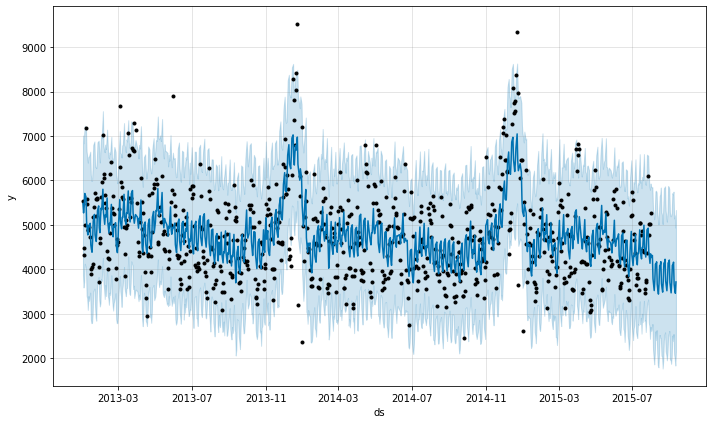

In [10]:
# visualizing predicions
my_model.plot(forecast);

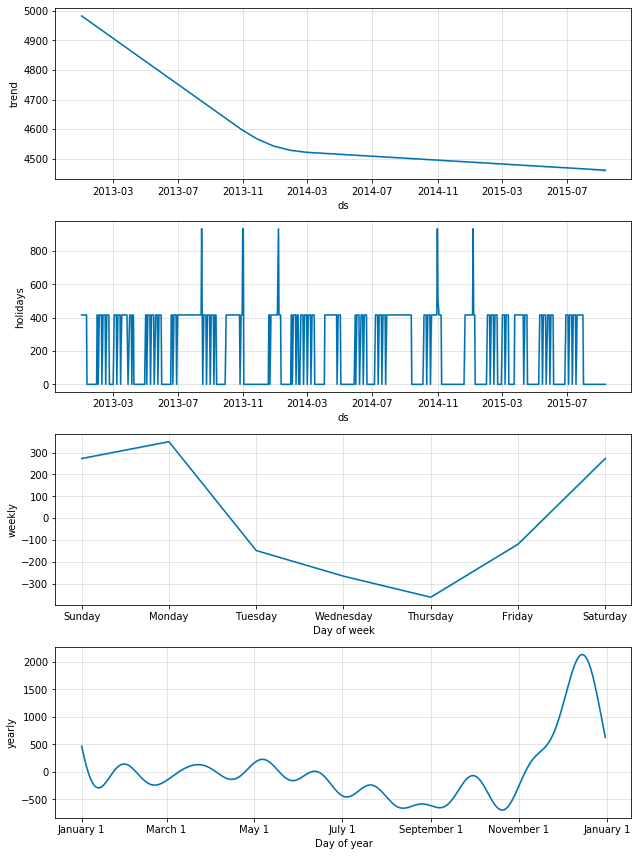

In [11]:
my_model.plot_components(forecast);